In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import spectrogram

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/ieeg_ieds_bids"

In [ ]:
subject = "sub-01"
subject_dir = os.path.join(data_path, subject)

os.listdir(subject_dir)

['ieeg']

In [ ]:
ieeg_dir = os.path.join(subject_dir, "ieeg")
os.listdir(ieeg_dir)

['sub-01_task-sleep_ieeg.edf',
 'sub-01_coordsystem.json',
 'sub-01_task-sleep_events.tsv',
 'sub-01_task-sleep_channels.tsv',
 'sub-01_task-sleep_events.json',
 'sub-01_task-sleep_ieeg.json',
 'sub-01_electrodes.tsv',
 'sub-01_task-sleep_channels.json']

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.1 MB/s eta 0:00:00


In [ ]:
import mne
import os

edf_file = [f for f in os.listdir(ieeg_dir) if f.endswith(".edf")][0]
edf_path = os.path.join(ieeg_dir, edf_file)

raw = mne.io.read_raw_edf(edf_path, preload=True)
raw

Extracting EDF parameters from /content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_task-sleep_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 180999  =      0.000 ...   180.999 secs...


<RawEDF | sub-01_task-sleep_ieeg.edf, 22 x 181000 (181.0 s), ~30.4 MiB, data loaded>

In [ ]:
import pandas as pd
import os

# Find the events file
events_file = [f for f in os.listdir(ieeg_dir) if "events.tsv" in f][0]
events_path = os.path.join(ieeg_dir, events_file)

events = pd.read_csv(events_path, sep="\t")
events.head()

,onset,duration,trial_type,sample
0,0.802,0.0,Rt sharp,802
1,5.614,0.0,Rt sharp,5614
2,5.906,0.0,Rt sharp,5906
3,12.864,0.0,Rt sharp,12864
4,17.583,0.0,Rt sharp,17583


In [ ]:
data = raw.get_data()           # shape: channels × samples
fs = raw.info["sfreq"]          # sampling rate
ch_names = raw.info["ch_names"]

print("Channels:", ch_names)
print("Data shape:", data.shape)
print("Sampling rate:", fs)

Channels: ['LA1', 'LA2', 'LA3', 'LMH1', 'LMH2', 'LMH3', 'RA1', 'RA3', 'RMH1', 'RMH2', 'RMH3', 'LA1-LA2', 'LA2-LA3', 'LA3-LA4', 'LMH1-LMH2', 'LMH2-LMH3', 'LMH3-LMH4', 'RA1-RA3', 'RA3-RA4', 'RMH1-RMH2', 'RMH2-RMH3', 'RMH3-RMH4']
Data shape: (22, 181000)
Sampling rate: 1000.0


**Visualizing a Raw iEEG Signal**

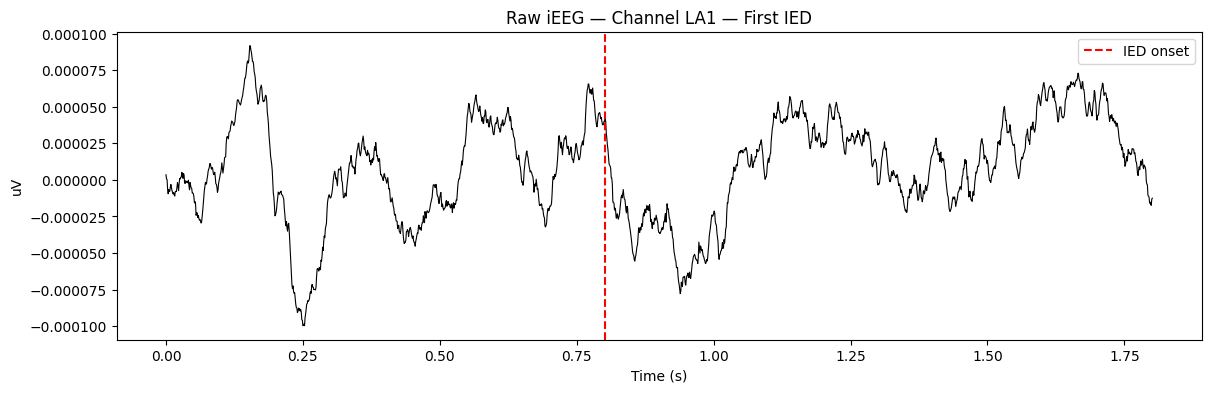

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

channel = "LA1"
ch_idx = ch_names.index(channel)

ev = events.iloc[3]
onset = ev["onset"]

# Make window but prevent negative indices
t0 = max(0, onset - 1)
t1 = onset + 1

i0 = int(t0 * fs)
i1 = int(t1 * fs)

snippet = data[ch_idx, i0:i1]
time = np.arange(i1 - i0) / fs + t0

plt.figure(figsize=(14,4))
plt.plot(time, snippet, lw=0.8, color='black')

plt.axvline(onset, color='red', linestyle='--', label="IED onset")

plt.title(f"Raw iEEG — Channel {channel} — First IED")
plt.xlabel("Time (s)")
plt.ylabel("uV")
plt.legend()
plt.show()

Areas of interest: no prime is on right side. A, H are good ones higher amplitude spikes. Contacts up to 4. 1: medial, 10: lateral cortex

**Closer look at IED Spike**

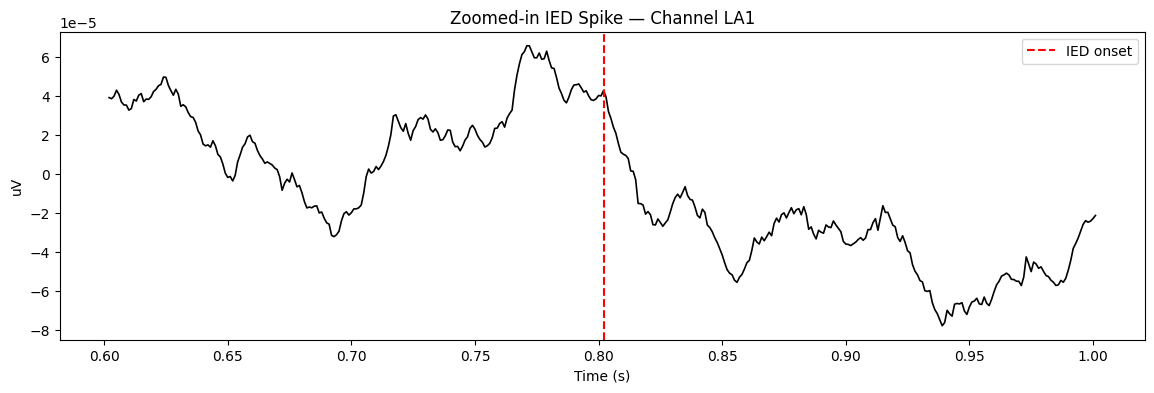

In [ ]:
channel = "LA1"        # same channel as before
ch_idx = ch_names.index(channel)

ev = events.iloc[0]
onset = ev["onset"]

# 200 ms on each side
t0 = onset - 0.2
t1 = onset + 0.2

# make sure we don't go below zero
t0 = max(0, t0)

i0 = int(t0 * fs)
i1 = int(t1 * fs)

snippet = data[ch_idx, i0:i1]
time = np.arange(i1 - i0) / fs + t0

plt.figure(figsize=(14,4))
plt.plot(time, snippet, lw=1.2, color='black')

plt.axvline(onset, color='red', linestyle='--', label="IED onset")

plt.title(f"Zoomed-in IED Spike — Channel {channel}")
plt.xlabel("Time (s)")
plt.ylabel("uV")
plt.legend()
plt.show()

**Averaged IED Waveform**

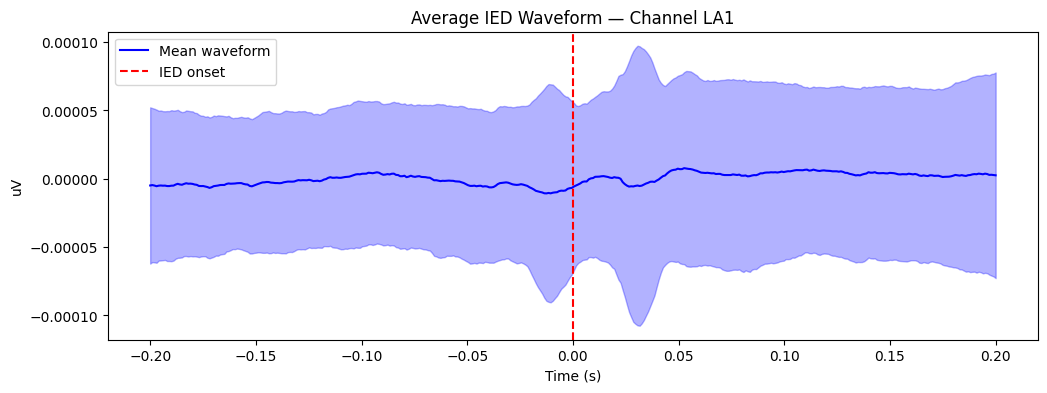

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

channel = "LA1"
ch_idx = ch_names.index(channel)

window = int(0.2 * fs)   # 200 ms on each side

snippets = []

for _, ev in events.iterrows():
    onset = ev["onset"]
    center = int(onset * fs)

    start = center - window
    end   = center + window

    # Skip events too close to the boundaries
    if start < 0 or end >= data.shape[1]:
        continue

    snippet = data[ch_idx, start:end]
    snippets.append(snippet)

snippets = np.array(snippets)

mean_wave = snippets.mean(axis=0)
std_wave  = snippets.std(axis=0)

time = np.linspace(-0.2, 0.2, mean_wave.size)

plt.figure(figsize=(12,4))
plt.plot(time, mean_wave, color='blue', label='Mean waveform')
plt.fill_between(time, mean_wave-std_wave, mean_wave+std_wave, color='blue', alpha=0.3)

plt.axvline(0, color='red', linestyle='--', label='IED onset')
plt.title(f"Average IED Waveform — Channel {channel}")
plt.xlabel("Time (s)")
plt.ylabel("uV")
plt.legend()
plt.show()

**Multi-Channel Spike Propagation (Stacked Channels)**

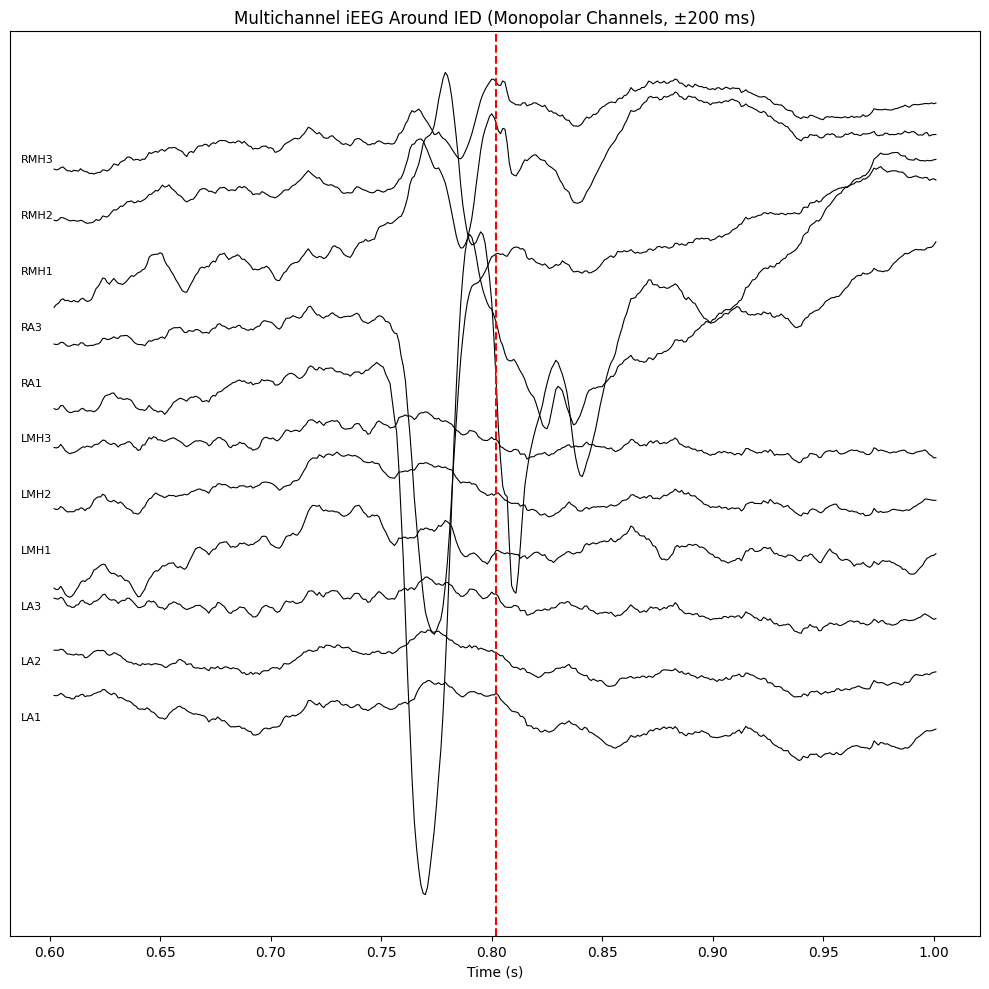

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the first IED
ev = events.iloc[0]
onset = ev["onset"]

# Window around event (±200 ms)
t0 = max(0, onset - 0.2)
t1 = onset + 0.2

i0 = int(t0 * fs)
i1 = int(t1 * fs)
time = np.arange(i1 - i0) / fs + t0

# Select only monopolar channels (no '-' in name)
mono_chs = [ch for ch in ch_names if "-" not in ch]
mono_indices = [ch_names.index(ch) for ch in mono_chs]

plt.figure(figsize=(10, 10))

spacing = 1e-4  # vertical spacing

offset = 0
for idx in mono_indices:
    snippet = data[idx, i0:i1]
    plt.plot(time, snippet + offset, color='black', linewidth=0.8)
    plt.text(t0 - 0.015, offset, ch_names[idx], fontsize=8, va='center')
    offset += spacing

plt.axvline(onset, color='red', linestyle='--')

plt.title("Multichannel iEEG Around IED (Monopolar Channels, ±200 ms)")
plt.xlabel("Time (s)")
plt.yticks([])
plt.tight_layout()
plt.show()
